In [43]:
import torch
import pandas as pd
import os.path as osp
import numpy as np

from functools import partial
from torch.utils.data import DataLoader

from changeit3d.in_out.pointcloud import (pc_loader_from_npz, 
                                          uniform_subsample, 
                                          swap_axes_of_pointcloud, 
                                          center_in_unit_sphere,
                                          PointcloudDataset)

from changeit3d.models.shape_part_segmentors import shape_net_parts_segmentor_inference, load_shape_net_parts_segmentor
from changeit3d.utils.basics import parallel_apply
from changeit3d.utils.visualization import plot_3d_point_cloud

In [12]:
## this is the transformation we use in our pretrained part-predictor-classifier
## YOU MUST Change this accordingly if you use a different part-predictor

def pc_transform_for_part_predictor(pc):
    pc = swap_axes_of_pointcloud(pc, [0, 2, 1])
    pc = center_in_unit_sphere(pc)
    return pc        

In [23]:
shape_part_classifiers_top_dir = '../../data/pretrained/part_predictors/shapenet_core_based/'

## Download shapetalk first:
split_file = '../../data/shapetalk/language/misc/unary_split_rs_2022.csv'
top_pc_dir = '../../data/shapetalk/point_clouds/scaled_to_align_rendering/'

In [82]:
shape_class = "table" # or "chair", "lamp"
pretrained_file_location = osp.join(shape_part_classifiers_top_dir, f'best_seg_model_{shape_class}.pth')
gpu_id = 1
random_seed = 2022
n_sample_points = 2048

In [83]:
device = torch.device("cuda:" + str(gpu_id))
evaluating_part_predictor = load_shape_net_parts_segmentor(pretrained_file_location, shape_class)
evaluating_part_predictor = evaluating_part_predictor.to(device)

In [84]:
# Find splits
splits = pd.read_csv(split_file)
test_uids = splits[(splits.object_class == shape_class) & (splits.split == "test")]['model_uid']
gt_pc_files = top_pc_dir + '/' + test_uids + '.npz'

In [85]:
# Load in memory corresponding pointclouds
pc_loader =  partial(pc_loader_from_npz, n_samples=n_sample_points, random_seed=random_seed)
gt_pcs = parallel_apply(gt_pc_files, pc_loader, n_processes=20) # or, gt_pcs = [pc_loader(m) for m in gt_pc_files]
gt_pcs = np.array(gt_pcs)

In [86]:
# Run inference
gt_loader = DataLoader(PointcloudDataset(gt_pcs, pc_transform=pc_transform_for_part_predictor), batch_size=128, num_workers=10)        
pred_parts = shape_net_parts_segmentor_inference(evaluating_part_predictor, gt_loader, device=device)

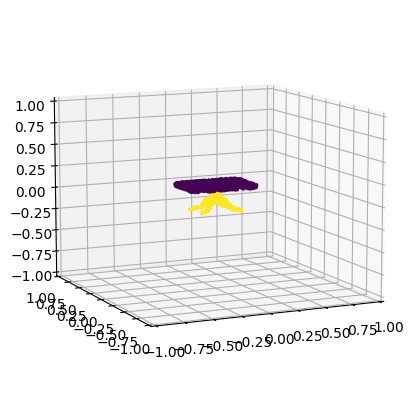

In [88]:
ridx = np.random.randint(len(gt_pcs))
plot_3d_point_cloud(gt_pcs[ridx], visualization_pc_axis=[0, 2, 1], c=pred_parts[ridx]);